# TF-TRT Inference from VNet Model Checkpoint with TF 1.15

In this notebook, we demonstrate the process to create a TF-TRT optimized model from a Tensorflow VNet model checkpoint.

This notebook was designed to run with TensorFlow version 1.15 which is included as part of NVIDIA NGC Tensorflow containers from `nvcr.io/nvidia/tensorflow:19.11-py3` to `nvcr.io/nvidia/tensorflow:19.12-tf1-py3` that can be downloaded from the [NGC website](https://ngc.nvidia.com/catalog/containers/nvidia:tensorflow).
 

## Notebook  Content
1. [Pre-requisite: data and model](#1)
1. [Verifying the orignal FP32 model](#2)
1. [Creating TF-TRT FP32 model](#3)
1. [Creating TF-TRT FP16 model](#4)
1. [Creating TF-TRT INT8 model](#5)
1. [Calibrating TF-TRT INT8 model with raw JPEG images](#6)
 
## Quick start
We will run this demonstration with a saved VNet model to be downloaded from https://ngc.nvidia.com/catalog/models/nvidia:vnettf_fp32.

The INT8 calibration process requires access to a small but representative sample of real training or valiation data.

We will use the Hippocampus dataset from [medical segmentation decathlon](http://medicaldecathlon.com/). Test images provided by the organization were used to produce the resulting masks for submission.


To run this notebook, follow the instruction at https://ngc.nvidia.com/catalog/model-scripts/nvidia:vnet_medical_for_tensorflow/quickStartGuide to build the required Docker container and download the Hippocampus dataset.

Start the NGC TF container, providing correct path to the Hippocampus dataset `/path/to/dataset` (if already downloaded):

```bash
 docker run --runtime=nvidia --rm -it --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 -v /path/to/dataset:/data vnet_tf:latest bash
```

Within the container, we then start Jupyter notebook with:

```bash
jupyter notebook --ip 0.0.0.0 --port 8888  --allow-root
```

Connect to Jupyter notebook web interface on your host http://localhost:8888.


<a id="1"></a>
## 1. Pre-requisite: data and model

We first import some required libraries.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import time
import logging
import numpy as np

import tensorflow as tf
print("TensorFlow version: ", tf.__version__)

from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants

logging.getLogger("tensorflow").setLevel(logging.ERROR)

# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorFlow version:  1.15.0
TensorRT version: 
ii  libnvinfer-bin                         6.0.1-1+cuda10.2                  amd64        TensorRT binaries
ii  libnvinfer-dev                         6.0.1-1+cuda10.2                  amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev                  6.0.1-1+cuda10.2                  amd64        TensorRT plugin libraries
ii  libnvinfer-plugin6                     6.0.1-1+cuda10.2                  amd64        TensorRT plugin libraries
ii  libnvinfer6                            6.0.1-1+cuda10.2                  amd64        TensorRT runtime libraries
ii  python3-libnvinfer                     6.0.1-1+cuda10.2                  amd64        Python 3 bindings for TensorRT
ii  python3-libnvinfer-dev                 6.0.1-1+cuda10.2                  amd64        Python 3 development package for TensorRT


### Data
If not already downloaded, the Hippocampus dataset from [medical segmentation decathlon](http://medicaldecathlon.com/) can be downloaded with the download_dataset.py script. It is possible to select the destination folder when downloading the files by using the --data_dir flag. For example:


In [2]:
!python ../download_dataset.py --data_dir ./data

Unpacking...
Traceback (most recent call last):
  File "../download_dataset.py", line 61, in <module>
    main()
  File "../download_dataset.py", line 50, in main
    tf = tarfile.open(os.path.join(FLAGS.data_dir, filename))
  File "/usr/lib/python3.6/tarfile.py", line 1576, in open
    raise ReadError("file could not be opened successfully")
tarfile.ReadError: file could not be opened successfully


In [3]:
!ls ./data/Task04_Hippocampus

dataset.json  imagesTr	imagesTs  labelsTr


According to the [paper](https://arxiv.org/pdf/1902.09063.pdf):

"The dataset consisted of MRI acquired in 90 healthy adults and 105 adults with a non-affective psychotic disorder (56 schizophrenia, 32 schizoaffective disorder, and 17 schizophreniform disorder) taken from the Psychiatric Genotype/Phenotype Project data repository at Vanderbilt University Medical Center (Nashville, TN, USA). Patients were recruited from the Vanderbilt Psychotic Disorders Program and controls were recruited from the surrounding community.  All participants were assessed with the Structured Clinical Interview for DSM-IV [15]. All subjects were free from significant med-ical or neurological illness, head injury, and active substance use or dependence.

Structural images were acquired with a 3D T1-weighted MPRAGE sequence(TI/TR/TE, 860/8.0/3.7 ms; 170 sagittal slices; voxel size, 1.0 mm3). All images were collected on a Philips Achieva scanner (Philips Healthcare, Inc., Best, The Netherlands). Manual tracing of the head, body, and tail of the hippocampus on images was completed following a previously published protocol [16, 17]. For the purposes of this dataset, the term hippocampus includes the hippocampus proper (CA1-4 and dentate gyrus) and parts of the subiculum, which together are more often termed the hippocampal formation [18]. The last slice of the head of the hippocampus was defined as the coronal slice containing theuncal apex. The resulting 195 labeled images are referred to as hippocampus atlases. Note that the term hippocampus posterior refers to the union of the body and the tail."

Next, let's inspect the downloaded dataset.

In [4]:
import sys
sys.path.insert(0, '/workspace/vnet/')
from utils.data_loader import MSDDataset

from utils.cmd_util import PARSER
FLAGS = PARSER.parse_args(["--exec_mode=predict","--batch_size=1", "--model_dir=./vnet_model",
                           "--data_dir=./data/Task04_Hippocampus"])

dataset = MSDDataset(json_path=os.path.join('./data/Task04_Hippocampus/dataset.json'),
                     dst_size=FLAGS.input_shape,
                     seed=FLAGS.seed,
                     interpolator=FLAGS.resize_interpolator,
                     data_normalization=FLAGS.data_normalization,
                     batch_size=FLAGS.batch_size,
                     train_split=0,
                     split_seed=FLAGS.split_seed)

FLAGS.labels = dataset.labels

#### Training data
There are 260 3-D training images of size 32 x 32 x 32, each with a segmentation label of the same size. 

In [5]:
import horovod.tensorflow as hvd
hvd.init()

with tf.Session(graph=tf.Graph()) as sess:
    test_data = dataset.eval_fn()
    iterator = test_data.make_one_shot_iterator()
    next_element = iterator.get_next()
    
    cnt = 0
    try:
        while True:        
            image_data = sess.run(next_element)    
            cnt += 1
    except tf.errors.OutOfRangeError as e:
        pass
    print("Total number of training images: ", cnt)
    print("Data: ", image_data[0].shape)
    print("Label: ",image_data[1].shape)    

Total number of training images:  260
Data:  (1, 32, 32, 32)
Label:  (1, 32, 32, 32)


Let us show one slide of a training image and associated labels: 

In [6]:
import matplotlib.pyplot as plt

img_id = 0
slide_id = 10

plt.figure(figsize = (10,10));
plt.imshow(image_data[0][img_id][slide_id], cmap='gray');
plt.title("1 slide of a 3-D training volume");

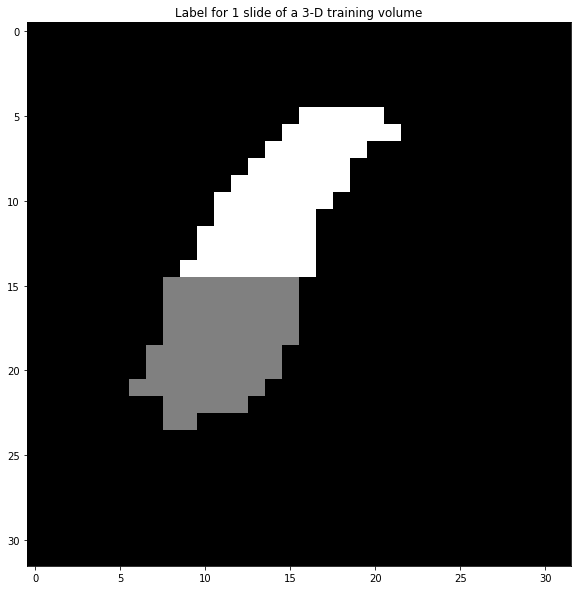

In [7]:
plt.figure(figsize = (10,10));
plt.imshow(image_data[1][img_id][slide_id], cmap='gray');
plt.title("Label for 1 slide of a 3-D training volume");

#### Test data
There are 130 3-D test images of size 32 x 32 x 32 without segmentation labels. 

In [8]:
with tf.Session(graph=tf.Graph()) as sess:
    test_data = dataset.test_fn()
    iterator = test_data.make_one_shot_iterator()
    next_element = iterator.get_next()
    
    cnt = 0
    try:
        while True:        
            image_data = sess.run(next_element)    
            cnt += 1
    except tf.errors.OutOfRangeError as e:
        pass
    print("Total number of test images: ", cnt)
    print("Data shape: ", image_data.shape)

Total number of test images:  130
Data shape:  (1, 32, 32, 32)


### VNet model checkpoint
If not already downloaded, we will be downloading and working with a VNet pretrained model from  https://ngc.nvidia.com/catalog/models/nvidia:vnettf_fp32.

In [9]:
%%bash 
wget -nc -q --show-progress -O vnet_model.zip \
https://api.ngc.nvidia.com/v2/models/nvidia/vnettf_fp32/versions/1/zip
unzip -o ./vnet_model.zip -d vnet_model

Archive:  ./vnet_model.zip
  inflating: vnet_model/checkpoint   
  inflating: vnet_model/eval/events.out.tfevents.1574423527.941577  
  inflating: vnet_model/events.out.tfevents.1574423303.941577  
  inflating: vnet_model/graph.pbtxt  
  inflating: vnet_model/joblog.log   
  inflating: vnet_model/model.ckpt-9360.data-00000-of-00001  
  inflating: vnet_model/model.ckpt-9360.index  
  inflating: vnet_model/model.ckpt-9360.meta  


<a id="2"></a>
## 2. Verifying the orignal VNet model checkpoint
First, we inspect the original VNet model loaded from the checkpoint. First, we set a global inference BATCH_SIZE we will work with.

In [10]:
BATCH_SIZE = 8
FLAGS.batch_size = BATCH_SIZE

dataset = MSDDataset(json_path=os.path.join('./data/Task04_Hippocampus/dataset.json'),
                     dst_size=FLAGS.input_shape,
                     seed=FLAGS.seed,
                     interpolator=FLAGS.resize_interpolator,
                     data_normalization=FLAGS.data_normalization,
                     batch_size=BATCH_SIZE,
                     train_split=0,
                     split_seed=FLAGS.split_seed)

In [11]:
from utils.model_fn import vnet_v2

gpu_options = tf.GPUOptions()
config = tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True)
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
config.gpu_options.allow_growth = True
    
run_config = tf.estimator.RunConfig(
    save_summary_steps=None,
    save_checkpoints_steps=None,
    save_checkpoints_secs=None,
    tf_random_seed=None,
    session_config=config,
    keep_checkpoint_max=1)
    
estimator = tf.estimator.Estimator(
    model_fn=vnet_v2,
    model_dir=FLAGS.model_dir,
    config=run_config,
    params=FLAGS)


Let's carry out prediction on a test image

In [12]:
predictions = estimator.predict(input_fn=lambda: dataset.test_fn(count=1))

In [13]:
pred = [p['prediction'] for p in predictions]

In [14]:
pred[0].shape

(32, 32, 32)

#### Export to saved model format
As TF-TRT works with saved model format, we shall now export the pretrained model to a saved model directory.

In [15]:
input_type = tf.float32

SAVED_MODEL_DIR = './saved_model'
!rm -rf $SAVED_MODEL_DIR

def get_serving_input_receiver_fn():

    def serving_input_receiver_fn():
        features = tf.placeholder(dtype=input_type, shape=(BATCH_SIZE, 32, 32, 32), name='input_tensor')

        return tf.estimator.export.TensorServingInputReceiver(features=features, receiver_tensors=features)

    return serving_input_receiver_fn

export_path = estimator.export_saved_model(
    export_dir_base='%s'%SAVED_MODEL_DIR,
    serving_input_receiver_fn=get_serving_input_receiver_fn(),
    checkpoint_path='./vnet_model/model.ckpt-9360'
)

We employ `saved_model_cli` to inspect the inputs and outputs of the model. Note that `estimator.export_saved_model` will create a random subdirectory within `SAVED_MODEL_DIR`.

In [16]:
!ls $SAVED_MODEL_DIR

1579143644


In [17]:
import os
subdir = os.popen('ls %s'%SAVED_MODEL_DIR).read().strip()

In [18]:
subdir

'1579143644'

In [19]:
SAVED_MODEL_DIR = os.path.join(SAVED_MODEL_DIR, subdir)
!saved_model_cli show --all --dir $SAVED_MODEL_DIR

2020-01-16 03:00:47.071724: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.2

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (8, 32, 32, 32)
        name: input_tensor:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['prediction'] tensor_info:
        dtype: DT_INT64
        shape: (8, 32, 32, 32)
        name: vnet/ArgMax:0
  Method name is: tensorflow/serving/predict


In [20]:
SAVED_MODEL_DIR

'./saved_model/1579143644'

This give us information on the input and output tensors as `input_tensor:0` and `softmax_tensor:0` respectively. Also note that the number of output classes here is 1001 instead of 1000 Imagenet classes. This is because the network was trained with an extra background class. 

In [21]:
INPUT_TENSOR = 'input_tensor:0'
OUTPUT_TENSOR = 'vnet/ArgMax:0'

Next, we define a function to read in a saved mode, measuring its speed and accuracy on the validation data.

In [22]:
def benchmark_saved_model(SAVED_MODEL_DIR, BATCH_SIZE=1):
    with tf.Session(graph=tf.Graph(), config=config) as sess:
        dataset = MSDDataset(json_path=os.path.join('./data/Task04_Hippocampus/dataset.json'),
                     dst_size=FLAGS.input_shape,
                     seed=FLAGS.seed,
                     interpolator=FLAGS.resize_interpolator,
                     data_normalization=FLAGS.data_normalization,
                     batch_size=BATCH_SIZE,
                     train_split=0,
                     split_seed=FLAGS.split_seed)
        
        # prepare dataset iterator
        test_data = dataset.test_fn()
        test_data = test_data.repeat()
        iterator = test_data.make_one_shot_iterator()
        next_element = iterator.get_next()

        tf.saved_model.loader.load(
            sess, [tf.saved_model.tag_constants.SERVING], SAVED_MODEL_DIR)
        
        node_list = [n.name for n in tf.get_default_graph().as_graph_def().node]
        
        print('Warming up for 50 batches...')
        for _ in range (50):
            sess.run(OUTPUT_TENSOR, feed_dict={INPUT_TENSOR: sess.run(next_element)})

        print('Benchmarking inference engine for 1000 batches...')
        num_predict = 0
        start_time = time.time()
        for _ in range (1000):       
                data = sess.run(next_element)
                sess.run(OUTPUT_TENSOR, feed_dict={INPUT_TENSOR: data})
                num_predict += data.shape[0]
                
        print('Inference speed: %.2f samples/s'%(num_predict/(time.time()-start_time)))

In [23]:
benchmark_saved_model(SAVED_MODEL_DIR, BATCH_SIZE=BATCH_SIZE)

Warming up for 50 batches...
Benchmarking inference engine for 1000 batches...
Inference speed: 770.01 samples/s


<a id="3"></a>
## 3. Creating TF-TRT FP32 model

Next, we convert the native TF FP32 model to TF-TRT FP32, then verify model accuracy and inference speed.

In [25]:
FP32_SAVED_MODEL_DIR = SAVED_MODEL_DIR+"_TFTRT_FP32/1"
!rm -rf $FP32_SAVED_MODEL_DIR

# Now we create the TFTRT FP32 engine
converter = trt.TrtGraphConverter(input_saved_model_dir=SAVED_MODEL_DIR,
                                  max_batch_size=BATCH_SIZE,
                                  precision_mode=trt.TrtPrecisionMode.FP32)
converter.convert()
converter.save(FP32_SAVED_MODEL_DIR)

benchmark_saved_model(FP32_SAVED_MODEL_DIR, BATCH_SIZE=BATCH_SIZE)

Warming up for 50 batches...
Benchmarking inference engine for 1000 batches...
Inference speed: 669.60 samples/s


<a id="4"></a>
## 4. Creating TF-TRT FP16 model

Next, we convert the native TF FP32 model to TF-TRT FP16, then verify model accuracy and inference speed.

In [26]:
FP16_SAVED_MODEL_DIR = SAVED_MODEL_DIR+"_TFTRT_FP16/1"
!rm -rf $FP16_SAVED_MODEL_DIR

# Now we create the TFTRT FP16 engine
converter = trt.TrtGraphConverter(input_saved_model_dir=SAVED_MODEL_DIR,
                                  max_batch_size=BATCH_SIZE,
                                  precision_mode=trt.TrtPrecisionMode.FP16)
converter.convert()
converter.save(FP16_SAVED_MODEL_DIR)

benchmark_saved_model(FP16_SAVED_MODEL_DIR, BATCH_SIZE=BATCH_SIZE)

Warming up for 50 batches...
Benchmarking inference engine for 1000 batches...
Inference speed: 1050.69 samples/s


<a id="5"></a>
## 5. Creating TF-TRT INT8 model

Creating TF-TRT INT8 inference model requires two steps:

- Step 1: Prepare a calibration dataset

- Step 2: Convert and calibrate the TF-TRT INT8 inference engine

### Step 1: Prepare a calibration dataset

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.

In [27]:
num_calibration_batches = 2
batched_input = np.zeros((BATCH_SIZE * num_calibration_batches, 32, 32, 32), dtype=np.float32)

with tf.Session(graph=tf.Graph(), config=config) as sess:
    # prepare dataset iterator
    dataset = MSDDataset(json_path=os.path.join('./data/Task04_Hippocampus/dataset.json'),
                 dst_size=FLAGS.input_shape,
                 seed=FLAGS.seed,
                 interpolator=FLAGS.resize_interpolator,
                 data_normalization=FLAGS.data_normalization,
                 batch_size=BATCH_SIZE,
                 train_split=0,
                 split_seed=FLAGS.split_seed)

    # prepare dataset iterator
    test_data = dataset.test_fn()
    test_data = test_data.repeat()
    iterator = test_data.make_one_shot_iterator()
    next_element = iterator.get_next()
    for i in range(num_calibration_batches):
        batched_input[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = sess.run(next_element)

print('Calibration data shape: ', batched_input.shape)

def calibration_input_fn_gen():
    for i in range(num_calibration_batches):
        yield batched_input[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :]
        
calibration_input_fn = calibration_input_fn_gen()        

Calibration data shape:  (16, 32, 32, 32)



### Step 2: Convert and calibrate the TF-TRT INT8 inference engine

The calibration step may take a while to complete.

In [28]:
# set a directory to write the saved model
INT8_SAVED_MODEL_DIR =  SAVED_MODEL_DIR + "_TFTRT_INT8/1"
!rm -rf $INT8_SAVED_MODEL_DIR
    
converter = trt.TrtGraphConverter(
      input_saved_model_dir=SAVED_MODEL_DIR,
      precision_mode=trt.TrtPrecisionMode.INT8)
  
converter.convert()

# Run calibration for num_calibration_batches times.
converted_graph_def = converter.calibrate(
      fetch_names=[OUTPUT_TENSOR],
      num_runs=num_calibration_batches,
      feed_dict_fn=lambda: {INPUT_TENSOR: next(calibration_input_fn)})

converter.save(INT8_SAVED_MODEL_DIR)
    

### Benchmarking INT8 saved model

Finally we reload and verify the accuracy and performance of the INT8 saved model from disk.

In [29]:
benchmark_saved_model(INT8_SAVED_MODEL_DIR, BATCH_SIZE=BATCH_SIZE)

Warming up for 50 batches...
Benchmarking inference engine for 1000 batches...
Inference speed: 1041.42 samples/s


In [30]:
!saved_model_cli show --all --dir $INT8_SAVED_MODEL_DIR

2020-01-16 03:07:02.754401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.2

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (8, 32, 32, 32)
        name: input_tensor:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['prediction'] tensor_info:
        dtype: DT_INT64
        shape: (8, 32, 32, 32)
        name: vnet/ArgMax:0
  Method name is: tensorflow/serving/predict


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT inference model from an original pretrained VNet model checkpoint. In every case, we have also verified the accuracy and speed to the resulting model. 
